# Model NPZD
Implementation of a NPZD based on the paper 'Internal dynamics of NPZD type ecosystem models'

Model equations:
\begin{align}
\frac{\partial N}{\partial t}&=-J(N,I)P+\phi_{z}Z+\gamma_{m}D \\
\frac{\partial P}{\partial t}&=(J(N,I)-\phi_{P})P-G(\epsilon,g,P)Z \\
\frac{\partial Z}{\partial t}&=(\beta G(\epsilon,g,P)-\phi_{z}-\phi^{*}_{Z}Z)Z \\
\frac{\partial D}{\partial t}&=\phi_{P}P+((1-\beta)G(\epsilon,g,P)+\phi^{*}_{Z}Z)Z-\gamma_{m}D
\end{align}
With:
\begin{align}
J(N,I)&=\mu_{m}\cdot f_{N}(N) \cdot f_{I}(I)=\mu_{m} \cdot \frac{N}{k_{N}+N} \cdot \frac{I}{k_{I}+I} \\
G(\epsilon,g,P)&=\frac{g \epsilon P^{2}}{g+\epsilon P^{2}}
\end{align}


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.integrate import odeint
from matplotlib.lines import Line2D

matplotlib.rcParams.update({
    'font.family': 'serif',
})

In [2]:
parameters_o={
"Cref":1.066,    # Growth coefficient of phytoplancton
"c":1,           # Growth coefficient of phytoplancton
"beta":0.925,     # Assimilation coefficient of zooplankton
"alpha":0.256,    # Slope of photoshynthesis vs linght intensity
"mum":0.870,      # Phytoplancton growth rate
"phip":0.04,        # Phytoplancton linear mortality
"phipqua":1.14,     # Phytoplancton quadratic mortality
"epsilon":1.6,      # Grazing encounter rate
"g":1.575,          # Maximum grazing rate
"phiz":0.01,        # Phytoplancton linear mortality
"phizqua":0.34,     # Phytoplancton quadratic mortality
"gammam":0.048,     # Detritus remineralization rate
"kn":0.7,           # Half saturation constant for NO3 uptake
"ki":0.5,           # Half saturation constant for light
"I":8.7,              # Light initial value


# Simulation values
"timestep":0.01,
"num_iter":100000,
}
parameters = parameters_o

In [3]:
# Model implementation
def phyto_growth(mum,kn,ki,N,I):
    return mum*(N/(kn+N))*(I/(ki+I))

def phyto_growth2(mum,kn,ki,N,I):
    return mum*(N/(kn+N))*(I/(ki+I))
    
def grazing_growth(g,epsilon,P):
    return (g*epsilon*(P**2))/(g+epsilon*(P**2))

def lqm_model(X,t):
    I=parameters['I']
    beta=parameters['beta']
    mum=parameters['mum']
    phip=parameters['phip']
    phipqua=parameters['phipqua']
    epsilon=parameters['epsilon']
    gammam=parameters['gammam']
    kn=parameters['kn']
    ki=parameters['ki']
    g=parameters['g']
    phiz=parameters['phiz']
    phizqua=parameters['phizqua']
    J = phyto_growth(mum,kn,ki,X[0],I)
    G = grazing_growth(g,epsilon,X[1])

    N= -J*X[1]+phiz*X[2]+gammam*X[3]
    P= (J-phip)*X[1]-G*X[2]
    Z= (beta*G-phiz-phizqua*X[2])*X[2]
    D= phip*X[1]+((1-beta)*G+phizqua*X[2])*X[2]-gammam*X[3]
    
    return np.array([N,P,Z,D]) 

# The las
def llm_model(X,t):
    I=parameters['I']
    beta=parameters['beta']
    mum=parameters['mum']
    kn=parameters['kn']
    ki=parameters['ki']
    g=parameters['g']
    epsilon=parameters['epsilon']
    gammam=parameters['gammam']
    phiz=parameters['phiz']
    phip=parameters['phip']
    
    J = phyto_growth(mum,kn,ki,X[0],I)
    G = grazing_growth(g,epsilon,X[1])
    
    N= -J*X[1]+phiz*X[2]+gammam*X[3] 
    P= (J-phip)*X[1]-G*X[2]
    Z= (beta*G-phiz)*X[2]
    D= phip*X[1]+(1-beta)*G*X[2]-gammam*X[3]
    
    return np.array([N,P,Z,D])

def qqm_model(X,t):
    I=parameters['I']
    beta=parameters['beta']
    mum=parameters['mum']
    kn=parameters['kn']
    ki=parameters['ki']
    g=parameters['g']
    epsilon=parameters['epsilon']
    gammam=parameters['gammam']
    phiz=parameters['phiz']
    phiz2=parameters['phizqua']
    phip=parameters['phip']
    phip2=parameters['phipqua']
    
    N,P,Z,D = X[0],X[1],X[2],X[3]
    
    J = phyto_growth(mum,kn,ki,X[0],I)
    G = grazing_growth(g,epsilon,X[1])
    
    Nn= (-J+phip)*P+phiz*Z+gammam*D 
    Pn= (J-phip-phip2*P)*P-G*Z
    Zn= (beta*G-phiz-phiz2*Z)*Z
    Dn= phip2*P*P+((1-beta)*G+phiz2*Z)*Z-gammam*D
    
    return np.array([Nn,Pn,Zn,Dn])

t = np.linspace(0, 25, 100000)  
X0 = np.array([1,1,1,1])  

X, infodict = odeint(llm_model, X0, t, full_output=True)

In [4]:
# Function to compute equilibrium points for a given model and S array values
def compute_equilibrium(model, ixs):
    eqs = [[],[],[],[]]

    for i in ixs:
        S = i
        # Create X0
        X = np.array([1,1,1,1])
        norm = S/(X.sum())
        X0 = X*norm
        # Create timespace
        t = np.linspace(0, 10000,100000)  
        # Compute model
        results, infodict = odeint(model, X0, t, full_output=True)
        # Store last value (convergence)
        for i in range(4): eqs[i].append(results[-1,i])

    return eqs

In [5]:
# PLOTTING TOOLS
def plot_npzd(ixs, eq_points, name, marker, every, lw, ls="solid"):
    colours = ['blue','green','red','gray']
    
    for i in range(4):
        plt.plot(ixs,
                 eq_points[i],
                 label="NPZD"[i]+'_'+name,
                 c=colours[i],
                 marker=marker,
                 markevery=every,
                 lw=lw, 
                 ls=ls)

# Create custom legend
npzd_legend = [Line2D([0], [0],marker="s", markerfacecolor='blue', markersize=10, color='w', lw=4),
                Line2D([0], [0],marker="s", markerfacecolor='green', markersize=10, color='w', lw=4),
                Line2D([0], [0],marker="s", markerfacecolor='red', markersize=10, color='w', lw=4),
                Line2D([0], [0],marker="s", markerfacecolor='grey',  markersize=10, color='w', lw=4)]
# plt.legend(custom_lines, ['N ', 'P ', 'Z ','D '], loc=2, prop={'size': 10})

### Raw model results

Equilibrium points LLM LQM QQM S=\[0,35\]

In [6]:
# Compute the equilibrium points for all S parameters in ixs
parameters = parameters_o
ixs = np.arange(0.01, 35, 0.5)
convs_llm_1 = compute_equilibrium(llm_model, ixs)
convs_lqm_1 = compute_equilibrium(lqm_model, ixs)
convs_qqm_1 = compute_equilibrium(qqm_model, ixs)

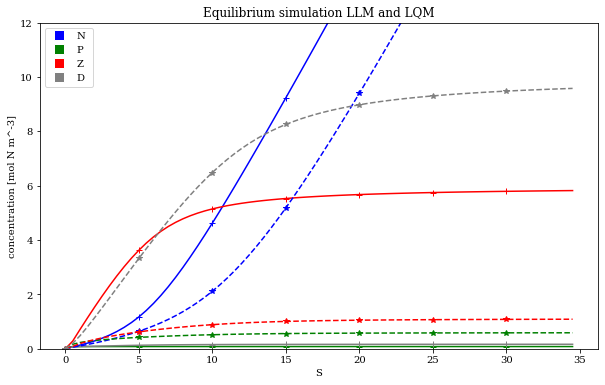

In [7]:
plt.figure(figsize=(10, 6))
plt.ylim(0,12)

# Plot llm
plot_npzd(ixs, convs_llm_1, name='llm', marker='+', every=10, lw=1.5, ls='solid')
# Plot lqm
plot_npzd(ixs, convs_lqm_1, name='lqm', marker='*', every=10, lw=1.5, ls='dashed')

# Create custom legend
plt.legend(npzd_legend, ['N ', 'P ', 'Z ','D '], loc=2, prop={'size': 10})

# Labels
plt.title('Equilibrium simulation LLM and LQM')
plt.xlabel('S')
plt.ylabel('concentration [mol N m^-3]')

plt.show()

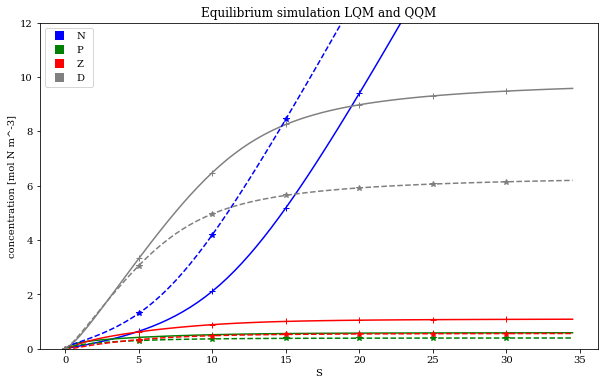

In [8]:
plt.figure(figsize=(10, 6))
plt.ylim(0,12)

# Plot lqm
plot_npzd(ixs, convs_lqm_1, name='llm', marker='+', every=10, lw=1.5, ls='solid')
# Plot qqm
plot_npzd(ixs, convs_qqm_1, name='lqm', marker='*', every=10, lw=1.5, ls='dashed')

# Create custom legend
plt.legend(npzd_legend, ['N ', 'P ', 'Z ','D '], loc=2, prop={'size': 10})

# Labels
plt.title('Equilibrium simulation LQM and QQM')
plt.xlabel('S')
plt.ylabel('concentration [mol N m^-3]')

plt.show()

Equilibrium points LLM LQM QQM S=\[0,210\]

In [9]:
ixs = np.arange(0.01, 210, 0.5)
convs_llm_2 = compute_equilibrium(llm_model, ixs)
convs_lqm_2 = compute_equilibrium(lqm_model, ixs)
convs_qqm_2 = compute_equilibrium(qqm_model, ixs)

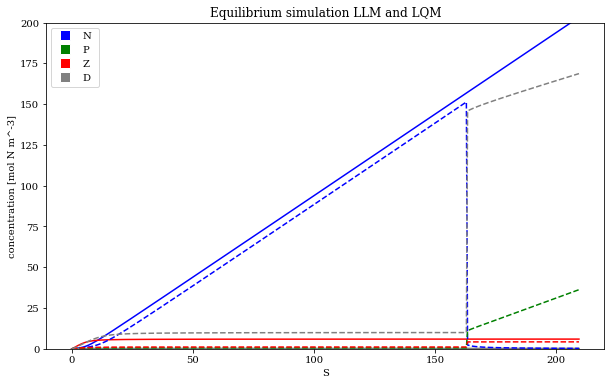

In [10]:
plt.figure(figsize=(10, 6))
plt.ylim(0,200)

# Plot llm
plot_npzd(ixs, convs_llm_2, name='llm', marker='', every=45, lw=1.5, ls='solid')
# Plot lqm
plot_npzd(ixs, convs_lqm_2, name='lqm', marker='', every=45, lw=1.5, ls='dashed')

# Create custom legend
plt.legend(npzd_legend, ['N ', 'P ', 'Z ','D '], loc=2, prop={'size': 10})

# Labels
plt.title('Equilibrium simulation LLM and LQM')
plt.xlabel('S')
plt.ylabel('concentration [mol N m^-3]')

plt.show()

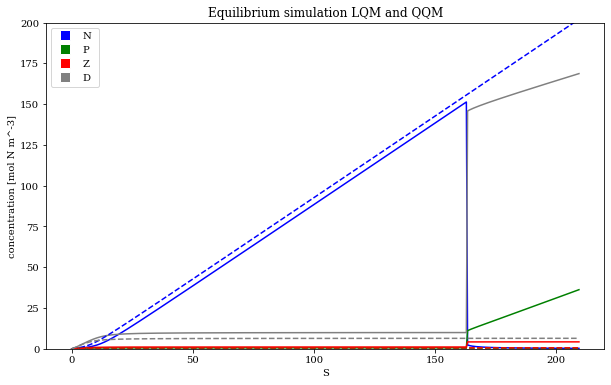

In [11]:
plt.figure(figsize=(10, 6))
plt.ylim(0,200)

# Plot llm
plot_npzd(ixs, convs_lqm_2, name='llm', marker='', every=45, lw=1.5, ls='solid')
# Plot lqm
plot_npzd(ixs, convs_qqm_2, name='lqm', marker='', every=45, lw=1.5, ls='dashed')

# Create custom legend
plt.legend(npzd_legend, ['N ', 'P ', 'Z ','D '], loc=2, prop={'size': 10})

# Labels
plt.title('Equilibrium simulation LQM and QQM')
plt.xlabel('S')
plt.ylabel('concentration [mol N m^-3]')

plt.show()

Equilibrium points LLM LQM QQM S=\[0,0.3\]

In [12]:
ixs = np.arange(0.001, 0.3, 0.0005)
convs_llm_3 = compute_equilibrium(llm_model, ixs)
convs_lqm_3 = compute_equilibrium(lqm_model, ixs)

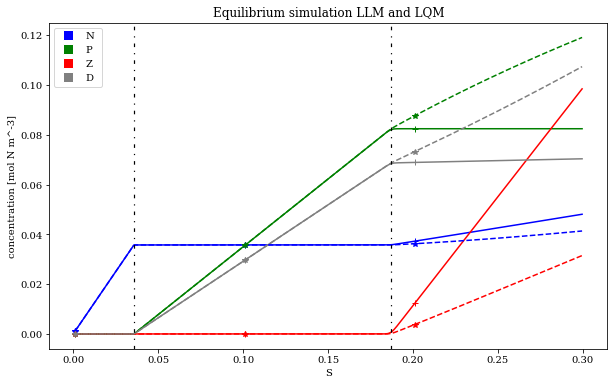

In [13]:
plt.figure(figsize=(10, 6))
#plt.ylim(0,200)

# Plot llm
plot_npzd(ixs, convs_llm_3, name='llm', marker='+', every=200, lw=1.5, ls='solid')
# Plot lqm
plot_npzd(ixs, convs_lqm_3, name='lqm', marker='*', every=200, lw=1.5, ls='dashed')
plt.axvline(x=0.036, lw=1.2, c="black",linestyle=(0, (3, 5, 1, 5)))
plt.axvline(x=0.187, lw=1.2, c="black",linestyle=(0, (3, 5, 1, 5)))
# Create custom legend
plt.legend(npzd_legend, ['N ', 'P ', 'Z ','D '], loc=2, prop={'size': 10})

# Labels
plt.title('Equilibrium simulation LLM and LQM')
plt.xlabel('S')
plt.ylabel('concentration [mol N m^-3]')

plt.show()

In [14]:
# parametros custom para este grafico
parameters={
"Cref":1.066,    # Growth coefficient of phytoplancton
"c":1,           # Growth coefficient of phytoplancton
"beta":0.925,     # Assimilation coefficient of zooplankton
"alpha":0.256,    # Slope of photoshynthesis vs linght intensity
"mum":0.870,      # Phytoplancton growth rate
"phip":0.04,        # Phytoplancton linear mortality
"phipqua":0.58,     # Phytoplancton quadratic mortality
"epsilon":1.6,      # Grazing encounter rate
"g":1.575,          # Maximum grazing rate
"phiz":0.01,        # Phytoplancton linear mortality
"phizqua":0.34,     # Phytoplancton quadratic mortality
"gammam":0.048,     # Detritus remineralization rate
"kn":0.7,           # Half saturation constant for NO3 uptake
"ki":0.5,           # Half saturation constant for light
"I":8.7,              # Light initial value


# Simulation values
"timestep":0.01,
"num_iter":100000,
}

In [15]:
ixs = np.arange(0.001, 0.3, 0.0005)
#convs_lqm_3 = compute_equilibrium(lqm_model, ixs)
convs_qqm_3 = compute_equilibrium(qqm_model, ixs)

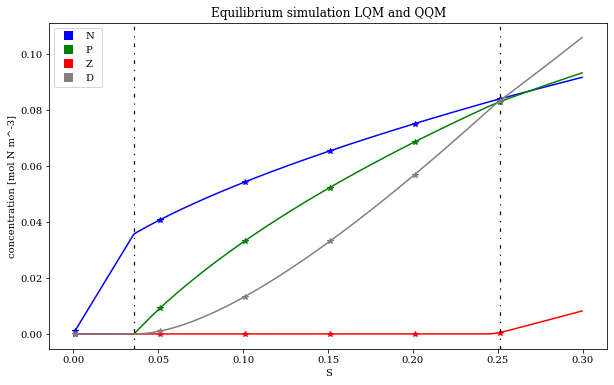

In [16]:
plt.figure(figsize=(10, 6))

# Plot llm
#plot_npzd(ixs, convs_lqm_3, name='llm', marker='+', every=200, lw=1.5, ls='solid')
# Plot lqm
plot_npzd(ixs, convs_qqm_3, name='lqm', marker='*', every=100, lw=1.5, ls='solid')
# Vertical lines
plt.axvline(x=0.036, lw=1.2, c="black",linestyle=(0, (3, 5, 1, 5)))
plt.axvline(x=0.251, lw=1.2, c="black",linestyle=(0, (3, 5, 1, 5)))

# Create custom legend
plt.legend(npzd_legend, ['N ', 'P ', 'Z ','D '], loc=2, prop={'size': 10})

# Labels
plt.title('Equilibrium simulation LQM and QQM')
plt.xlabel('S')
plt.ylabel('concentration [mol N m^-3]')

plt.show()

## Light intensity modelling


**Light intensity functions**

Attenuation function based on S

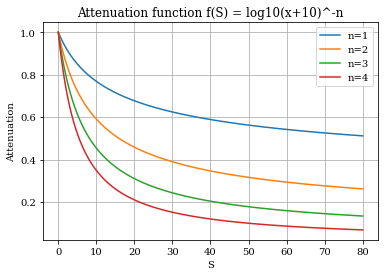

In [17]:
S = np.linspace(0,80,1000)
for i in range(1,5) : plt.plot(S, np.log10(S+10)**-i, label=f'n={i}')
plt.legend()
plt.grid(True)
plt.title('Attenuation function f(S) = log10(x+10)^-n')
plt.xlabel('S')
plt.ylabel('Attenuation')
plt.savefig('imgs/f_s.pdf')


Weighted attenuation function

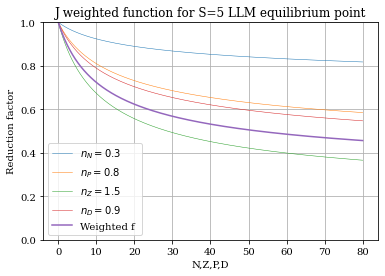

In [39]:
S = np.linspace(0,80,1000)
let = [
    np.log10(S+10)**-0.3,
    np.log10(S+10)**-0.8,
    np.log10(S+10)**-1.5,
    np.log10(S+10)**-0.9,
]
comp = 1/5*let[0]+0*let[1]+4/5*let[2]+0*let[3]

plt.figure(figsize=(6, 4))


plt.plot(S, let[0], label=r'$n_N=0.3$', lw=0.5)
plt.plot(S, let[1], label=r'$n_P=0.8$', lw=0.5)
plt.plot(S, let[2], label=r'$n_Z=1.5$', lw=0.5)
plt.plot(S, let[3], label=r'$n_D=0.9$', lw=0.5)
plt.plot(S, comp, label=r'Weighted f ', lw=1.5)


plt.ylim(0,1.0)
#plt.xlim(-0.5,5.5)
plt.legend(loc=0)
plt.grid(True)
plt.title('J weighted function for S=5 LLM equilibrium point')
plt.xlabel('N,Z,P,D')
plt.ylabel('Reduction factor')
#plt.xticks(list(plt.xticks()[0]))
plt.savefig('imgs/f_swheighted.pdf')


Seasonal light variation

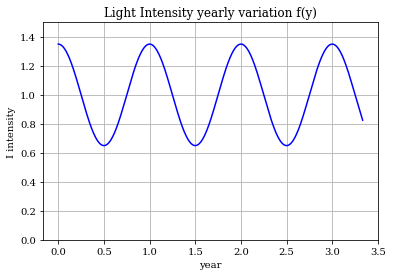

In [31]:
a = 0
day = np.linspace(0,1200,1000)
res = 0.35*np.cos(day*2*np.pi/360)+1
plt.plot(day/360,res,lw=1.5,c="blue")
plt.grid(True)
plt.title('Light Intensity yearly variation f(y)')
plt.xlabel('year')
plt.ylabel('I intensity')
plt.ylim(0,1.5)
plt.savefig('imgs/f_year.pdf')


Daily light variation function

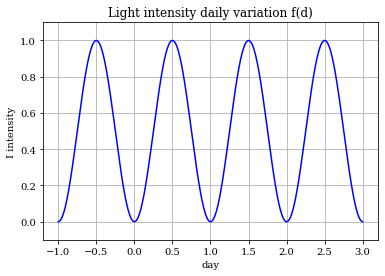

In [33]:
a= 0
day = np.linspace(-1,3,1000)
res = (-np.cos((day-a/24)*2*3.14)+1)/2
plt.plot(day,res,lw=1.5,c="blue")
plt.grid(True)
plt.title('Light intensity daily variation f(d)')
plt.xlabel('day')
plt.ylabel('I intensity')
plt.ylim(-0.1,1.1)
plt.savefig('imgs/f_day.pdf')


**Results with light simulation**

Simulation with simple light attenuation based on parameter S

In [40]:
# SIMULACION CON FUNCION LOG10 N=1
def phyto_growth_S(mum,kn,ki,N,I,S):
    return mum*(N/(kn+N))*np.log10(S+10)**(-1)

def lqm_model_s(X,t):
    I=parameters['I']
    beta=parameters['beta']
    mum=parameters['mum']
    phip=parameters['phip']
    phipqua=parameters['phipqua']
    epsilon=parameters['epsilon']
    gammam=parameters['gammam']
    kn=parameters['kn']
    ki=parameters['ki']
    g=parameters['g']
    phiz=parameters['phiz']
    phizqua=parameters['phizqua']
    
    J = phyto_growth_S(mum,kn,ki,X[0],I,np.sum(X))
    G = grazing_growth(g,epsilon,X[1])

    N= -J*X[1]+phiz*X[2]+gammam*X[3]
    P= (J-phip)*X[1]-G*X[2]
    Z= (beta*G-phiz-phizqua*X[2])*X[2]
    D= phip*X[1]+((1-beta)*G+phizqua*X[2])*X[2]-gammam*X[3]
    
    return np.array([N,P,Z,D]) 

# The las
def llm_model_s(X,t):
    I=parameters['I']
    beta=parameters['beta']
    mum=parameters['mum']
    kn=parameters['kn']
    ki=parameters['ki']
    g=parameters['g']
    epsilon=parameters['epsilon']
    gammam=parameters['gammam']
    phiz=parameters['phiz']
    phip=parameters['phip']
    
    J = phyto_growth_S(mum,kn,ki,X[0],I,np.sum(X))
    G = grazing_growth(g,epsilon,X[1])
    
    N= -J*X[1]+phiz*X[2]+gammam*X[3] 
    P= (J-phip)*X[1]-G*X[2]
    Z= (beta*G-phiz)*X[2]
    D= phip*X[1]+(1-beta)*G*X[2]-gammam*X[3]
    
    return np.array([N,P,Z,D])

def qqm_model_s(X,t):
    I=parameters['I']
    beta=parameters['beta']
    mum=parameters['mum']
    kn=parameters['kn']
    ki=parameters['ki']
    g=parameters['g']
    epsilon=parameters['epsilon']
    gammam=parameters['gammam']
    phiz=parameters['phiz']
    phiz2=parameters['phizqua']
    phip=parameters['phip']
    phip2=parameters['phipqua']
    
    N,P,Z,D = X[0],X[1],X[2],X[3]
    
    J = phyto_growth_S(mum,kn,ki,X[0],I, np.sum(X))
    G = grazing_growth(g,epsilon,X[1])
    
    Nn= (-J+phip)*P+phiz*Z+gammam*D 
    Pn= (J-phip-phip2*P)*P-G*Z
    Zn= (beta*G-phiz-phiz2*Z)*Z
    Dn= phip2*P*P+((1-beta)*G+phiz2*Z)*Z-gammam*D
    
    return np.array([Nn,Pn,Zn,Dn])

In [22]:
parameters = parameters_o
ixs = np.arange(0.01, 35, 0.5)
convs_llm_41 = compute_equilibrium(llm_model, ixs)
convs_llm_42 = compute_equilibrium(llm_model_s, ixs)

Text(0, 0.5, 'concentration [mol N m^-3]')

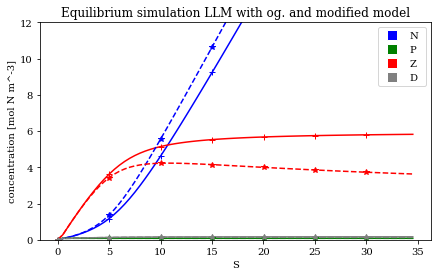

In [70]:
plt.figure(figsize=(7, 4))
plt.ylim(0,12)

# Plot llm
plot_npzd(ixs, convs_llm_41, name='llm', marker='+', every=10, lw=1.5, ls='solid')
# Plot lqm
plot_npzd(ixs, convs_llm_42, name='llm2', marker='*', every=10, lw=1.5, ls='dashed')
# Custom legend
plt.legend(npzd_legend, ['N ', 'P ', 'Z ','D '], loc=0, prop={'size': 10})

# Labels
plt.title('Equilibrium simulation LLM with og. and modified model')
plt.xlabel('S')
plt.ylabel('concentration [mol N m^-3]')
plt.savefig('imgs/eq_sat_llm.pdf')


In [24]:
parameters = parameters_o
ixs = np.arange(0.01, 35, 0.5)
convs_lqm_41 = compute_equilibrium(lqm_model, ixs)
convs_lqm_42 = compute_equilibrium(lqm_model_s, ixs)

Text(0, 0.5, 'concentration [mol N m^-3]')

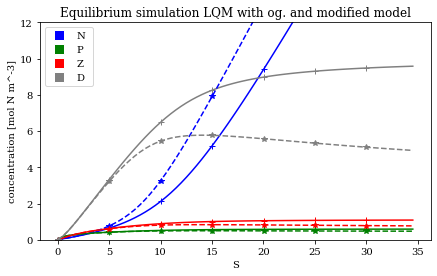

In [69]:
plt.figure(figsize=(7, 4))
plt.ylim(0,12)

# Plot llm
plot_npzd(ixs, convs_lqm_41, name='llm', marker='+', every=10, lw=1.5, ls='solid')
# Plot lqm
plot_npzd(ixs, convs_lqm_42, name='llm2', marker='*', every=10, lw=1.5, ls='dashed')
# Custom legend
plt.legend(npzd_legend, ['N ', 'P ', 'Z ','D '], loc=0, prop={'size': 10})

# Labels
plt.title('Equilibrium simulation LQM with og. and modified model')
plt.xlabel('S')
plt.ylabel('concentration [mol N m^-3]')


In [26]:
parameters = parameters_o
ixs = np.arange(0.01, 35, 0.5)
convs_qqm_41 = compute_equilibrium(qqm_model, ixs)
convs_qqm_42 = compute_equilibrium(qqm_model_s, ixs)

Text(0, 0.5, 'concentration [mol N m^-3]')

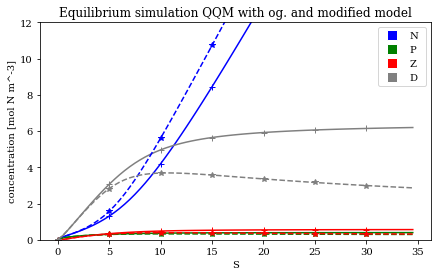

In [68]:
plt.figure(figsize=(7, 4))
plt.ylim(0,12)

# Plot llm
plot_npzd(ixs, convs_qqm_41, name='llm', marker='+', every=10, lw=1.5, ls='solid')
# Plot lqm
plot_npzd(ixs, convs_qqm_42, name='llm2', marker='*', every=10, lw=1.5, ls='dashed')
# Custom legend
plt.legend(npzd_legend, ['N ', 'P ', 'Z ','D '], loc=0, prop={'size': 10})

# Labels
plt.title('Equilibrium simulation QQM with og. and modified model')
plt.xlabel('S')
plt.ylabel('concentration [mol N m^-3]')


Simulation with temporal light modelling

In [44]:
def phyto_growth_t(mum,kn,ki,N,I,t):
    return mum*(N/(kn+N))*(0.35*np.cos(t*2*3.14/360)+1)

def lqm_model_t(X,t):
    I=parameters['I']
    beta=parameters['beta']
    mum=parameters['mum']
    phip=parameters['phip']
    phipqua=parameters['phipqua']
    epsilon=parameters['epsilon']
    gammam=parameters['gammam']
    kn=parameters['kn']
    ki=parameters['ki']
    g=parameters['g']
    phiz=parameters['phiz']
    phizqua=parameters['phizqua']
    
    J = phyto_growth_t(mum,kn,ki,X[0],I,t)
    G = grazing_growth(g,epsilon,X[1])

    N= -J*X[1]+phiz*X[2]+gammam*X[3]
    P= (J-phip)*X[1]-G*X[2]
    Z= (beta*G-phiz-phizqua*X[2])*X[2]
    D= phip*X[1]+((1-beta)*G+phizqua*X[2])*X[2]-gammam*X[3]
    
    return np.array([N,P,Z,D]) 

def llm_model_t(X,t):
    I=parameters['I']
    beta=parameters['beta']
    mum=parameters['mum']
    kn=parameters['kn']
    ki=parameters['ki']
    g=parameters['g']
    epsilon=parameters['epsilon']
    gammam=parameters['gammam']
    phiz=parameters['phiz']
    phip=parameters['phip']
    
    J = phyto_growth_t(mum,kn,ki,X[0],I,t)
    G = grazing_growth(g,epsilon,X[1])
    
    N= -J*X[1]+phiz*X[2]+gammam*X[3] 
    P= (J-phip)*X[1]-G*X[2]
    Z= (beta*G-phiz)*X[2]
    D= phip*X[1]+(1-beta)*G*X[2]-gammam*X[3]
    
    return np.array([N,P,Z,D])

def qqm_model_t(X,t):
    I=parameters['I']
    beta=parameters['beta']
    mum=parameters['mum']
    kn=parameters['kn']
    ki=parameters['ki']
    g=parameters['g']
    epsilon=parameters['epsilon']
    gammam=parameters['gammam']
    phiz=parameters['phiz']
    phiz2=parameters['phizqua']
    phip=parameters['phip']
    phip2=parameters['phipqua']
    
    N,P,Z,D = X[0],X[1],X[2],X[3]
    
    J = phyto_growth_t(mum,kn,ki,X[0],I,t)
    G = grazing_growth(g,epsilon,X[1])
    
    Nn= (-J+phip)*P+phiz*Z+gammam*D 
    Pn= (J-phip-phip2*P)*P-G*Z
    Zn= (beta*G-phiz-phiz2*Z)*Z
    Dn= phip2*P*P+((1-beta)*G+phiz2*Z)*Z-gammam*D
    
    return np.array([Nn,Pn,Zn,Dn])

In [45]:
# SINGLE SIMULATION
def single_run(model, S, t):
    # Create X0
    X = np.array([1,1,1,1])
    norm = S/(X.sum())
    X0 = X*norm
    # Compute model
    results, infodict = odeint(model, X0, t, full_output=True)
    
    return results.T

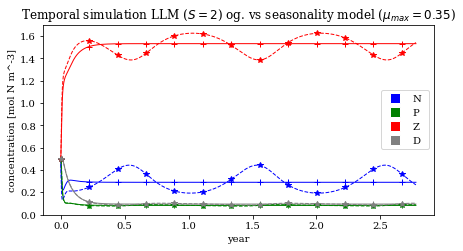

In [64]:
plt.figure(figsize=(7, 3.5))

# Plot llm
t = np.linspace(0, 1000,10000)  
llm = single_run(llm_model, 2,t)
llm_t = single_run(llm_model_t, 2,t)
plot_npzd(t/360, llm, name='season', marker='+', every=800, lw=1, ls='solid')
plot_npzd(t/360, llm_t, name='season', marker='*', every=800, lw=1., ls='dashed')
#Custom legend
plt.legend(npzd_legend, ['N ', 'P ', 'Z ','D '], loc=0, prop={'size': 10})


# Labels
plt.title('Temporal simulation LLM ($S=2$) og. vs seasonality model ($\mu_{max}=0.35$)')
plt.xlabel('year')
plt.ylabel('concentration [mol N m^-3]')
plt.show()

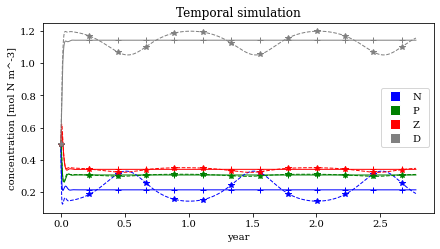

In [59]:
plt.figure(figsize=(7, 3.5))

# Plot llm
t = np.linspace(0, 1000,10000)  
lqm = single_run(lqm_model, 2,t)
lqm_t = single_run(lqm_model_t, 2,t)
plot_npzd(t/360, lqm, name='season', marker='+', every=800, lw=1, ls='solid')
plot_npzd(t/360, lqm_t, name='season', marker='*', every=800, lw=1., ls='dashed')
#Custom legend
plt.legend(npzd_legend, ['N ', 'P ', 'Z ','D '], loc=0, prop={'size': 10})


# Labels
plt.title('Temporal simulation LQM ($S=2$) og. vs seasonality model ($\mu_{max}=0.35$)')
plt.xlabel('year')
plt.ylabel('concentration [mol N m^-3]')
plt.show()

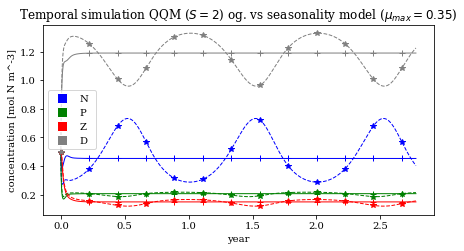

In [65]:
plt.figure(figsize=(7, 3.5))

# Plot llm
t = np.linspace(0, 1000,10000)  
qqm = single_run(qqm_model, 2,t)
qqm_t = single_run(qqm_model_t, 2,t)
plot_npzd(t/360, qqm, name='season', marker='+', every=800, lw=1, ls='solid')
plot_npzd(t/360, qqm_t, name='season', marker='*', every=800, lw=1., ls='dashed')
#Custom legend
plt.legend(npzd_legend, ['N ', 'P ', 'Z ','D '], loc=0, prop={'size': 10})


# Labels
plt.title('Temporal simulation QQM ($S=2$) og. vs seasonality model ($\mu_{max}=0.35$)')
plt.xlabel('year')
plt.ylabel('concentration [mol N m^-3]')
plt.show()

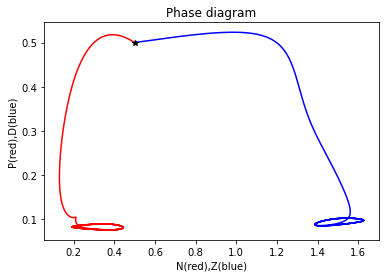

In [146]:
colours = ['blue','green','red','gray']
    
plt.plot(results.T[0,:],results.T[1,:], c='r',marker='',markevery=10,lw=1.5)
plt.plot(results.T[2,:],results.T[3,:], c='b',marker='',markevery=10,lw=1.5)
plt.plot(results.T[0,0],results.T[1,0], c='black', marker='*')
# Labels
plt.title('Phase diagram')
plt.xlabel('N(red),Z(blue)')
plt.ylabel('P(red),D(blue)')
plt.show()

## PDF Graphics

**Plot J saturation functions**

Plot of the following function and its components
\begin{align}
J(N,I)&=\mu_{m}\cdot f_{N}(N) \cdot f_{I}(I)=\mu_{m} \cdot \frac{N}{k_{N}+N} \cdot \frac{I}{k_{I}+I} \\
\end{align}


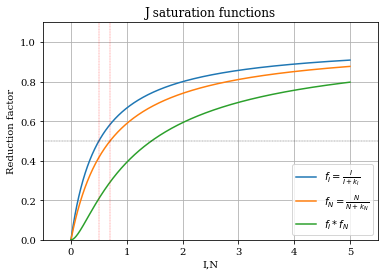

In [74]:
S = np.linspace(0,5,1000)
f1 = S/(0.5+S)
f2 = S/(0.7+S)
fn = f1*f2
plt.plot(S, f1, label=r'$f_I=\frac{I}{I+k_I}$')
plt.plot(S, f2, label=r'$f_N=\frac{N}{N+k_N}$')
plt.plot(S, fn, label=r'$f_I*f_N$')
plt.axvline(x=0.5, lw=0.3, c="red",linestyle='--')
plt.axvline(x=0.7, lw=0.3, c="red", linestyle='--')
plt.axhline(y=0.5, lw=0.3, c="black", linestyle='--')
plt.axhline(y=1/0.7)
plt.ylim(0,1.1)
plt.xlim(-0.5,5.5)
plt.legend(loc=4)
plt.grid(True)
plt.title('J saturation functions')
plt.xlabel('I,N')
plt.ylabel('Reduction factor')
#plt.xticks(list(plt.xticks()[0]))
plt.savefig('imgs/J_sat.pdf')



### Misc

Implementation of a predator prey model

$\begin{cases} \dot{N}=N*(a-b*P) \\ \dot{P}=P*(c*N-d) \end{cases}$

In [77]:
import numpy as np
import matplotlib.pyplot as plt

In [147]:
# Data containers
n_steps = 10000*3
N = np.zeros(n_steps)
P = np.zeros(n_steps)
# Initial values
N[0] = 0.2
P[0] = 0.8

In [148]:
dt = 0.0001

In [149]:
# Params
a = 60
b = 180
c = 80
d = 20

In [151]:
# Uses euler method
for i in range(n_steps-1):
    dn = N[i]*(a-b*P[i])
    dp = P[i]*(c*N[i]-d)
    if np.isinf(dn):
        print(i)
        break
    N[i+1] = N[i]*(1+dn*dt)
    P[i+1] = P[i]*(1+dp*dt)

First constant: 0.33, second constant: 0.25


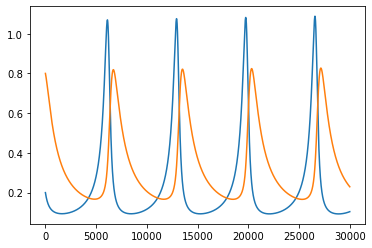

In [156]:
# TODO: Improve visualizations
print(f"First constant: {a/b:.2f}, second constant: {d/c:.2f}")
plt.plot(N[:i])
plt.plot(P[:i])